In [8]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import torch
import time
import os
import numpy as np
import imageio.v3 as io
from pathlib import Path
import glob
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from wrappers_matching_utils import geom_verification, plot_imgs, compute_relative_pose, plot_imgs_and_kpts
# os.makedirs('md1500_plots', exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from wrappers_manager import wrappers_manager

device = 'cuda'
max_kpts = 2048

wrapper_engine = 'superpoint'  # 'superpoint', 'disk', 'dedode', 'strek', 'mix_kpts_descs'
wrapper = wrappers_manager(wrapper_engine, device=device)

# from mix_kpts_desc_wrapper import MixKptsDescsWrapper
# wrapper = MixKptsDescsWrapper(detector='ripe', descriptor='disk')

from libutils.utils_matches import MNN
matcher = MNN(min_score=0.5, ratio_test=1, device=device)

Creating wrapper for superpoint on device cuda.

Loaded SuperPoint model


Undistorted_SfM/0022/images/2384872477_5b6ce13006_o.jpg Undistorted_SfM/0022/images/2244694791_ec4eee64cc_o.jpg


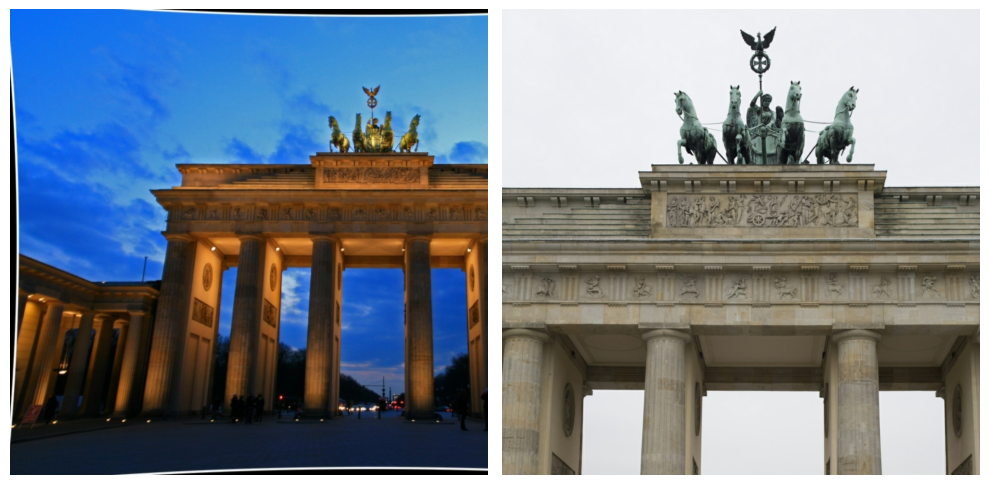

(torch.Size([3, 816, 832]), torch.Size([3, 816, 832]))

In [10]:
base_path = Path('/home/mattia/Desktop/Repos/megadepth_1500/megadepth_1500') 

pairs = {
    "easy"   :{"scene_name":'0022_0.5_0.7', 'pair':298},
    "medium" :{"scene_name":'0022_0.3_0.5', 'pair':4},
    "hard"   :{"scene_name":'0022_0.1_0.3', 'pair':3},
}
pair = pairs['medium']

gt_data = np.load(f'{base_path}/{pair["scene_name"]}.npz', allow_pickle=True)

id_A = gt_data['pair_infos'][pair['pair']][0][0]
id_B = gt_data['pair_infos'][pair['pair']][0][1]
im_A_path = gt_data['image_paths'][id_A]
im_B_path = gt_data['image_paths'][id_B]

print(im_A_path, im_B_path)

img_A_np = io.imread(base_path / im_A_path)
img_B_np =  io.imread(base_path / im_B_path)
x_min = min(img_A_np.shape[0], img_B_np.shape[0])
y_min = min(img_A_np.shape[1], img_B_np.shape[1])
img_A_np = img_A_np[:x_min, :y_min]
img_B_np = img_B_np[:x_min, :y_min]

img_A = wrapper.img_from_numpy(img_A_np).to(device)
img_B = wrapper.img_from_numpy(img_B_np).to(device)

plot_imgs([img_A_np, img_B_np])
img_A.shape, img_B.shape

In [11]:
from libutils_md.geometry import compute_fundamental_from_relative_motion

K_A, pose_A = gt_data['intrinsics'][id_A], gt_data['poses'][id_A]
K_B, pose_B = gt_data['intrinsics'][id_B], gt_data['poses'][id_B]
R_A, t_A = pose_A[:3,:3], pose_A[:3,3]
R_B, t_B = pose_B[:3,:3], pose_B[:3,3]

R, t = compute_relative_pose(R_A, t_A, R_B, t_B)

# scale up
import torch.nn.functional as F
factor = 1
K_A = K_A.copy()
K_B = K_B.copy()
K_A[:2, :] *= factor
K_B[:2, :] *= factor
img_A = F.interpolate(img_A.unsqueeze(0), scale_factor=factor, mode='bilinear', align_corners=False).squeeze(0)
img_B = F.interpolate(img_B.unsqueeze(0), scale_factor=factor, mode='bilinear', align_corners=False).squeeze(0)

F_gt = compute_fundamental_from_relative_motion(R, t, K_A, K_B)

In [12]:
with torch.inference_mode():#, torch.amp.autocast(device_type='cuda', dtype=torch.float16):
    out1 = wrapper.extract(img_A, max_kpts=max_kpts)
    out2 = wrapper.extract(img_B, max_kpts=max_kpts)

kpts1, des1 = out1.kpts, out1.des
kpts2, des2 = out2.kpts, out2.des
print(kpts1.shape, des1.shape, kpts2.shape, des2.shape)

matches = matcher.match([des1], [des2])[0].matches
kpts1_matched = kpts1[matches[:, 0]].cpu().numpy()
kpts2_matched = kpts2[matches[:, 1]].cpu().numpy()
print('matched:', kpts1_matched.shape, kpts2_matched.shape)

torch.Size([922, 2]) torch.Size([922, 256]) torch.Size([1310, 2]) torch.Size([1310, 256])
matched: (320, 2) (320, 2)


geom. verified: 36

median reprojection error A: 6.835836410522461
median reprojection error B: 3.450586199760437
Matches good: 16 Matches bad: 20


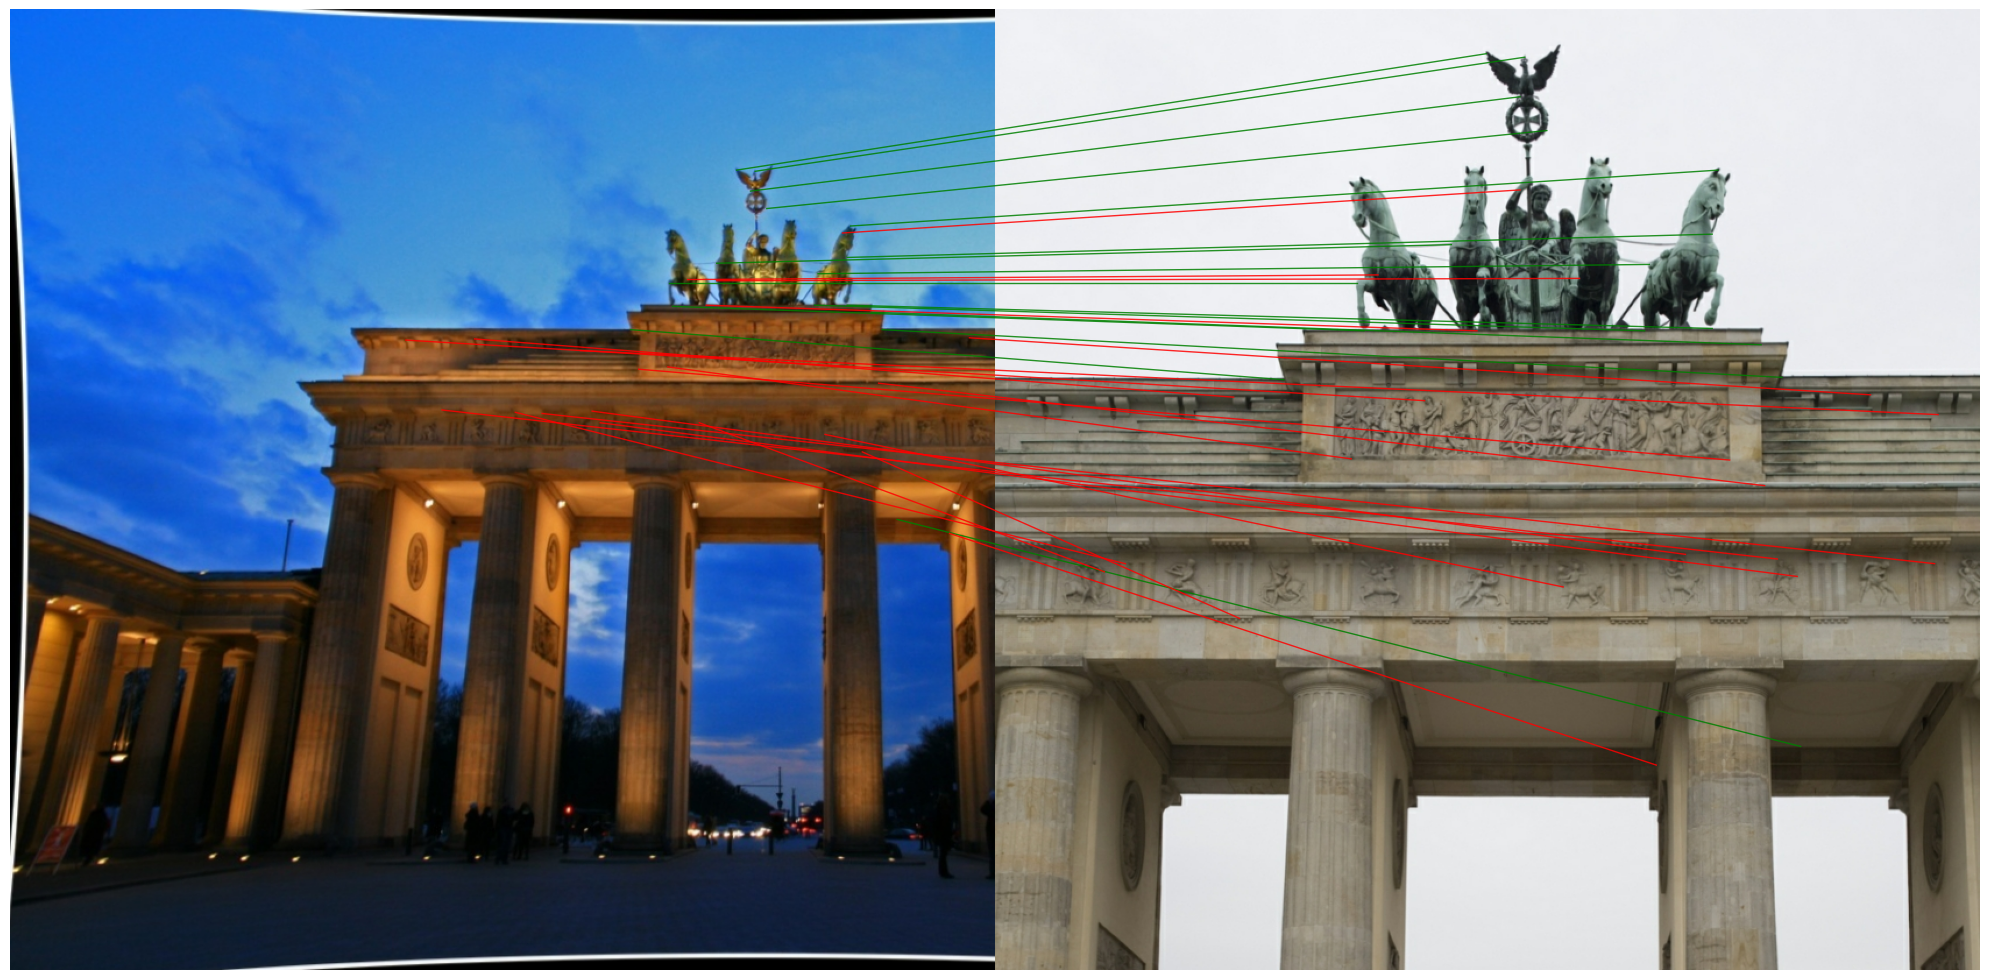

In [13]:
kpts1_matched, kpts2_matched, F = geom_verification(kpts1_matched, kpts2_matched, max_iter=1_000_000)

plot_imgs_and_kpts(img_A_np, img_B_np, kpts1_matched, kpts2_matched, figsize=(20,10), space=0, matches=True, index=False, pad=True, scatter=False, sample_points=1000, 
highlight_bad_matches=True, F_gt=F_gt)#, plot_name=f'md1500_plots/{wrapper.name}_{im_A_path.split("/")[-1]}_{im_B_path.split("/")[-1]}.png')

In [14]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

### extraction with SANDesc

In [ ]:
sys.path.append('/home/mattia/Desktop/Repos/sandesc')
path = f'/home/mattia/Desktop/Repos/sandesc/final_models/{wrapper_engine.split("-")[0]}/final.pth'
print('loading model from:', path)

weights = torch.load(path,  map_location=device, weights_only=False)
config = weights['config']
model_config = {'ch_in': config['model_config']['unet_ch_in'],
                'kernel_size': config['model_config']['unet_kernel_size'],
                'activ': config['model_config']['unet_activ'],
                'norm': config['model_config']['unet_norm'],
                'skip_connection': config['model_config']['unet_with_skip_connections'],
                'spatial_attention': config['model_config']['unet_spatial_attention'],
                'third_block': config['model_config']['third_block'],
                }
print('model config for model.pth:', model_config)

from model.network_descriptor import *
network = Unet_with_SPATT(**model_config).eval().to(device)

network.load_state_dict(weights['state_dict'])
wrapper.descriptor_network = network
wrapper.add_custom_descriptors(network)

In [ ]:
with torch.inference_mode():#, torch.amp.autocast(device_type='cuda', dtype=torch.float16):
    out1 = wrapper.extract(img_A, max_kpts=max_kpts)
    out2 = wrapper.extract(img_B, max_kpts=max_kpts)

kpts1, des1 = out1.kpts, out1.des
kpts2, des2 = out2.kpts, out2.des
print(kpts1.shape, des1.shape, kpts2.shape, des2.shape)


matches = matcher.match([des1], [des2])[0].matches
kpts1_matched = kpts1[matches[:, 0]].cpu().numpy()
kpts2_matched = kpts2[matches[:, 1]].cpu().numpy()
print(kpts1_matched.shape, kpts2_matched.shape)

In [ ]:
kpts1_matched, kpts2_matched, F = geom_verification(kpts1_matched[:-2],kpts2_matched[:-2], max_iter=1_000_000)

plot_imgs_and_kpts(img_A_np, img_B_np, kpts1_matched, kpts2_matched, figsize=(20,10), space=0, matches=True, index=False, pad=True, scatter=False, sample_points=1000, 
highlight_bad_matches=True, F_gt=F_gt, plot_name=f'md1500_plots/{wrapper.name}+sandesc_{im_A_path.split("/")[-1]}_{im_B_path.split("/")[-1]}.png')

In [ ]:
f'{wrapper.name}+sandesc_{im_A_path.split("/")[-1]}_{im_B_path.split("/")[-1]}.png'